In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score

from prep_data import load_data, apply_pca


In [6]:
X, y = load_data()


In [7]:
# cols = X.columns.str.contains('strengths|weakness|compared_to_others')


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

print(y_train.mean(), y_test.mean())


0.12688270196257417 0.1259124087591241


In [9]:
#####################
### DECISION TREE ###
#####################

In [10]:
# https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

clf.score(X_train, y_train)

1.0

<AxesSubplot:xlabel='ccp_alphas', ylabel='impurities'>

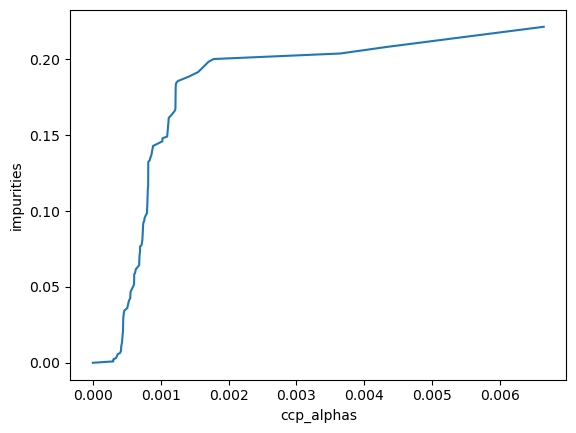

In [11]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
path = clf.cost_complexity_pruning_path(X_train, y_train)
path = pd.DataFrame(path)

sns.lineplot(path, x = 'ccp_alphas', y='impurities')

In [43]:
parameters = {
    'criterion': ('entropy', 'gini'),
    'splitter': ('best', 'random'),
    'ccp_alpha': np.arange(0, 0.061, 0.01),
    'class_weight': ('balanced', None),
    'max_features': ('sqrt', None),
    'min_samples_split': np.arange(2, 12, 1),
    'min_samples_leaf': np.arange(1, 6, 1),
    'max_depth': np.arange(1, 30, 1),
}

N=10000
clf = DecisionTreeClassifier(random_state=0)
cv = RandomizedSearchCV(clf, parameters, verbose=1, n_iter=N, scoring='f1', n_jobs=-1)
cv.fit(X_train, y_train)


Fitting 5 folds for each of 162400 candidates, totalling 812000 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
                         'class_weight': ('balanced', None),
                         'criterion': ('entropy', 'gini'),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'max_features': ('sqrt', None),
                         'min_samples_leaf': array([1, 2, 3, 4, 5]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'splitter': ('best', 'random')},
             scoring='f1', verbose=1)

In [44]:
# 1 - y_train.mean()
"""
BEST FIT, SCORE:

({'splitter': 'random',
  'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_features': None,
  'max_depth': 4,
  'criterion': 'entropy',
  'class_weight': 'balanced',
  'ccp_alpha': 0.0},
 0.35471647742643686)
 
({'ccp_alpha': 0.01,
  'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 8,
  'splitter': 'random'},
 0.3563555143317525)
"""
cv.best_params_, cv.best_score_

({'ccp_alpha': 0.01,
  'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 8,
  'splitter': 'random'},
 0.3563555143317525)

{'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'random'} 0.3563555143317525


<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

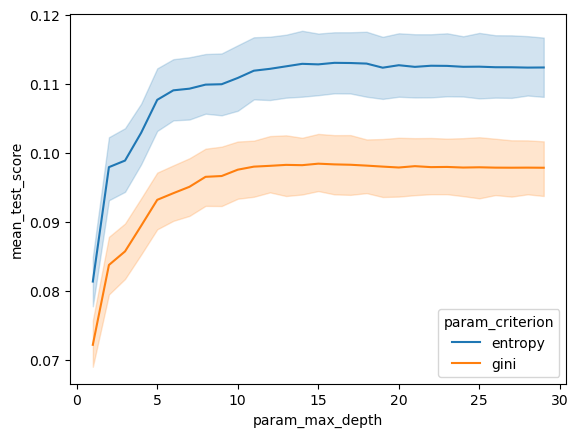

In [45]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results.loc[cv_results.param_class_weight != 'balanced', 'param_class_weight'] = 'None'

print(cv.best_params_, cv.best_score_)

best_estimator = cv.best_estimator_

sns.lineplot(
    cv_results,
    x='param_max_depth', 
    y='mean_test_score',
    hue='param_criterion',
)


In [47]:
print(
    'F1 Scores:\n',
    'train score:', f1_score(best_estimator.predict(X_train), y_train), '\n',
    'test score:', f1_score(best_estimator.predict(X_test), y_test),
)

print(
    'Accuracies:\n',
    'train score:', best_estimator.score(X_train, y_train), '\n',
    'test score:', best_estimator.score(X_test, y_test),
)

confusion_matrix(best_estimator.predict(X_train), y_train)


F1 Scores:
 train score: 0.3676470588235293 
 test score: 0.30952380952380953
Accuracies:
 train score: 0.8037425832952989 
 test score: 0.7883211678832117


array([[1636,  153],
       [ 277,  125]])

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


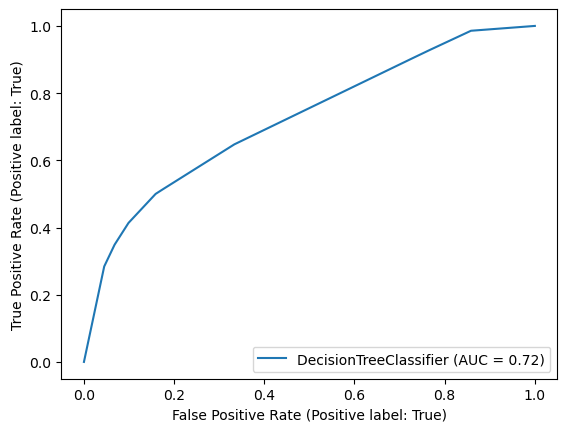

In [25]:
plot_roc_curve(best_estimator, X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


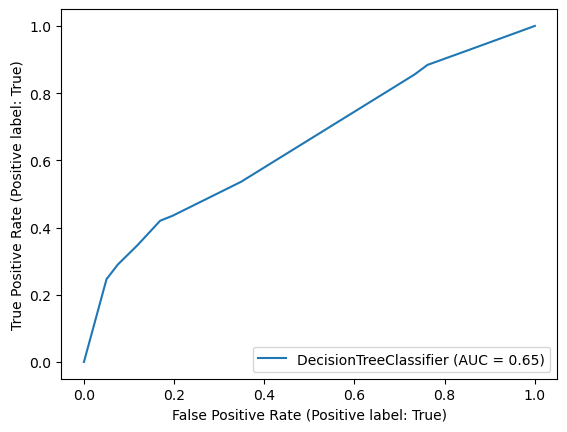

In [26]:
plot_roc_curve(best_estimator, X_test, y_test)